# Imports

In [26]:
import datetime
import os
import sys
from dataclasses import dataclass
#import sklearn
#from sklearn import model_selection
#from sklearn.model_selection import TimeSeriesSplit, train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Set the current working directory and get paths of load profiles

In [27]:

cwd = os.getcwd()

In [28]:
def get_directories(path) -> list:
    """
    Returns a list of directories in the given path.
    """
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
directories = get_directories('Profiles')
directories.sort()

# Builds load profile dataframe using all Excel Files

In [ ]:
def load_profile_df(filename) -> pd.DataFrame:
    """
    Converts xls and xlsx files to pandas dataframe.
    """
    print(filename)
    f = cwd+'/Profiles/'+filename+'/'+os.listdir(cwd+'/Profiles/'+filename)[0]
    print(f)
    if f.endswith('.xls') or f.endswith('.xlsx'):
        df = pd.read_excel(f, sheet_name=None)
        df = pd.concat(df)
        #print(df)
        df.drop("ADDTIME", axis=1, inplace=True)
        df.rename(columns={"PType_WZ":"Station"}, inplace=True)
        df.drop((df.columns)[-4:], axis=1, inplace=True)
        original_columns = list(df.columns)
        #print(original_columns)
        original_columns[0] = "Station"
        original_columns = ["Load at Interval {}".format(i) for i in range(1, len(original_columns[:])-1)]
        interval_column_labels = original_columns
        
        original_columns.insert(0, "Station")
        original_columns.insert(1, "Date")
        #df['Load Intervals'] = df[interval_column_labels].shift(len(interval_column_labels)-1, axis = "columns")
        #df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
        #print(original_columns)
        df.columns = original_columns
        #print(df.columns)
        #df.groupby(df.index.day).mean()
        #df.set_index('Date', inplace=True)
        #df.set_index(interval_column_labels, inplace=True)
        print(df.head())
    else:
        print('File type not supported. ', f)
        sys.exit()
    return df, interval_column_labels
def concat_all_excel_dfs(directories):
    full_df = pd.DataFrame()
    for d in directories:
        df, _ = load_profile_df(d)
        full_df = pd.concat([full_df, df], ignore_index = True)
    return full_df
my_load_profiles = concat_all_excel_dfs(directories)


# Plots a single day and also prints first 5 rows, shape, columns, and index of the load profile dataframe

MY LOAD DATAFRAME: 
         Station       Date  Load at Interval 1  Load at Interval 2  \
0  BUSHIDG_COAST 2016-01-01              11.489              11.413   
1  BUSHIDG_COAST 2016-01-02              11.668              11.589   
2  BUSHIDG_COAST 2016-01-03              11.457              11.381   
3  BUSHIDG_COAST 2016-01-04              11.358              11.280   
4  BUSHIDG_COAST 2016-01-05              11.492              11.418   

   Load at Interval 3  Load at Interval 4  Load at Interval 5  \
0              11.364              11.325              11.312   
1              11.538              11.494              11.472   
2              11.332              11.291              11.271   
3              11.228              11.182              11.162   
4              11.373              11.338              11.336   

   Load at Interval 6  Load at Interval 7  Load at Interval 8  ...  \
0              11.307              11.273              11.273  ...   
1              11.464 

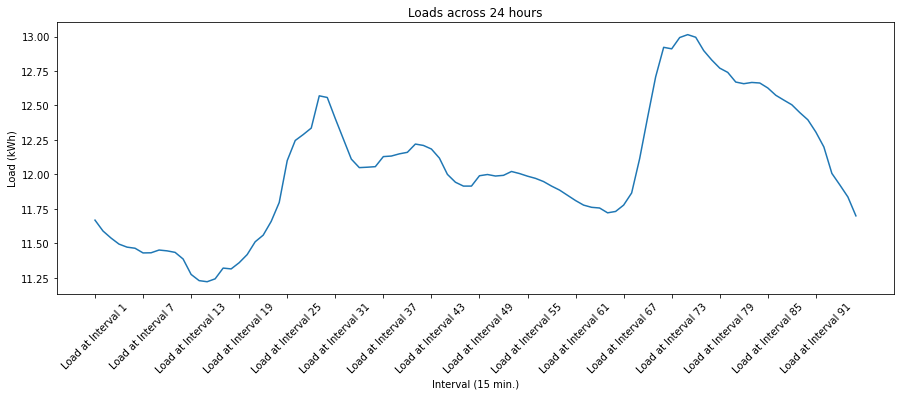

In [ ]:
'''Plot/Evaluate Data'''
def plot_load_data(df):
    """
    Plot the load data for each row in the dataframe."""
    df.drop(df.columns[:2], axis=1, inplace=True)
    #print(df.head())
    plt.figure(figsize=(15,5))
    plt.plot(df.iloc[1, :])
    plt.title("Loads across 24 hours")
    plt.xticks(np.arange(0, len(df.columns), 6), df.columns[::6], rotation=45)
    plt.xlabel("Interval (15 min.)")
    plt.ylabel("Load (kWh)")
    plt.show()
    #df.plot()
print("MY LOAD DATAFRAME: ")
print(my_load_profiles.head())
print(my_load_profiles.shape)
print(my_load_profiles.columns)
print(my_load_profiles.index)
plot_load_data(my_load_profiles)


# Moving Average Model to be used as baseline

<AxesSubplot:title={'center':'Moving Average'}>

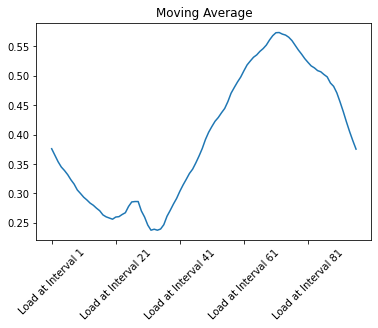

In [51]:
def moving_average(df, window):
    """
    Calculates the moving average of a given dataframe.
    """
    return df.rolling(window=window).mean()
lp_df = my_load_profiles.copy()
#lp_df = lp_df.T
ma_df = moving_average(lp_df, window=3)

    
#ma_df = ma_df.T
#print(ma_df)
#lp_df['Moving_Avg'] = ma_df
#print(ma_df)
ma_df.iloc[-1].plot(rot=45, title='Moving Average')

# Training, Validation Split

In [52]:

train_df = my_load_profiles[:int(len(my_load_profiles) * 0.9)]
val_df = my_load_profiles[int(len(my_load_profiles) * 0.1):]
train_df.fillna(0, inplace = True)
val_df.fillna(0, inplace = True)
#print(train_df.isnull().any())
#print(val_df.isnull().any())

def moving_average(df, window):
    """
    Calculates the moving average of a given dataframe.
    """
    return df.rolling(window=window).mean()
vdf = val_df.copy()
#lp_df = lp_df.T
vdma_df = moving_average(vdf, window=3)
#ma_df = ma_df.T
#print(ma_df)
#lp_df['Moving_Avg'] = ma_df



/home/austin/Desktop/Repositories/dae/LFv/lib/python3.9/site-packages/pandas/core/frame.py:5171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Load at Interval 1     False
Load at Interval 2     False
Load at Interval 3     False
Load at Interval 4     False
Load at Interval 5     False
                       ...  
Load at Interval 92    False
Load at Interval 93    False
Load at Interval 94    False
Load at Interval 95    False
Load at Interval 96    False
Length: 96, dtype: bool
Load at Interval 1     False
Load at Interval 2     False
Load at Interval 3     False
Load at Interval 4     False
Load at Interval 5     False
                       ...  
Load at Interval 92    False
Load at Interval 93    False
Load at Interval 94    False
Load at Interval 95    False
Load at Interval 96    False
Length: 96, dtype: bool


In [48]:
nn = tf.keras.Sequential([
    tf.keras.layers.Dense(96, input_shape=(96,), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(96, activation='relu'),
])
nn.compile(optimizer='adam', loss='mean_absolute_error')
target_df = train_df.shift(1, axis = 0)
target_df.fillna(0, inplace=True)
print(target_df)
nn.fit(train_df, target_df, epochs=10)
nn_predictions = nn.predict(val_df)
#nn_predictions = pd.DataFrame(nn_predictions)
#print(nn_predictions)

print(nn.summary())

        Load at Interval 1  Load at Interval 2  Load at Interval 3  \
0                    0.000               0.000               0.000   
1                   11.489              11.413              11.364   
2                   11.668              11.589              11.538   
3                   11.457              11.381              11.332   
4                   11.358              11.280              11.228   
...                    ...                 ...                 ...   
448403              11.020              10.875              10.732   
448404              10.542              10.414              10.298   
448405              10.169              10.040               9.917   
448406              10.901              10.744              10.577   
448407              10.960              10.808              10.650   

        Load at Interval 4  Load at Interval 5  Load at Interval 6  \
0                    0.000               0.000               0.000   
1                  

# Akaike Information Criterion (AIC), out-of-sample error estimate, lower AIC values indicate higher fidelity for out of sample predictions.

In [49]:
#print(nn_predictions)
#print(val_df)
nn_mse =  np.mean((nn_predictions - val_df)**2)
moving_average_mse = ((vdma_df-vdf)**2).mean()
print(nn_mse)
print(moving_average_mse)
def aic(mse, k):
    return 2 * k - 2 * mse
aic_nn_mse = aic(nn_mse, k=19058)
aic_vdma_mse = aic(moving_average_mse, k=3)

print("NEURAL NETWORK AIC")
print(aic_nn_mse)
print("MOVING AVERAGE AIC")
print(aic_vdma_mse)


Load at Interval 1     1981.105482
Load at Interval 2     1957.522672
Load at Interval 3     1835.571349
Load at Interval 4     2009.220969
Load at Interval 5     1892.249093
                          ...     
Load at Interval 92    2022.699118
Load at Interval 93    1815.151324
Load at Interval 94    1957.972836
Load at Interval 95    1772.693569
Load at Interval 96    1891.205408
Length: 96, dtype: float64
Load at Interval 1     44.709656
Load at Interval 2     44.265243
Load at Interval 3     43.828849
Load at Interval 4     43.401055
Load at Interval 5     42.997063
                         ...    
Load at Interval 92    48.373281
Load at Interval 93    62.819200
Load at Interval 94    61.684273
Load at Interval 95    60.597084
Load at Interval 96    59.556783
Length: 96, dtype: float64
NEURAL NETWORK AIC
Load at Interval 1     34153.789035
Load at Interval 2     34200.954655
Load at Interval 3     34444.857303
Load at Interval 4     34097.558061
Load at Interval 5     34331.501813